# Clustering with scikit-learn

We want to explore how to use scikit-learn for clustering. This includes preparing the data, training the model, and evaluating and visualizing the results.

We will use the following modules for this:
* [sklearn.datasets](https://scikit-learn.org/stable/api/sklearn.datasets.html): Tools for using common datasets for ML or for generating synthetic data
* [sklearn.model_selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html): Tools for data splitting, cross-validation, and parameter tuning
* [sklearn.cluster](https://scikit-learn.org/stable/api/sklearn.cluster.html): Collection of clustering models
* [sklearn.metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html): Collection of various metrics for model evaluation

**In general, also refer to the comprehensive [User Guide on clustering](https://scikit-learn.org/stable/modules/clustering.html) from scikit-learn.**

In [1]:
# Just in case we need help
# Import bia-bob as a helpful Python & Medical AI expert
from bia_bob import bob
import os

bob.initialize(
    endpoint='https://kiara.sc.uni-leipzig.de/api/v1', 
    model="vllm-llama-4-scout-17b-16e-instruct",
    system_prompt=os.getenv('SYSTEM_PROMPT_MEDICAL_AI')
)

In [2]:
%bob Who are you ? Just 1 sentence!

I am a medical data science AI assistant, an expert in Python programming and data analysis, specializing in tasks like data analysis, feature engineering, machine learning, and deep learning for medical datasets.

## Clustering on synthetic data

### Data preparation

For a start and to show the concepts of clustering with scikit-learn, we generate synthetic data for a simple clustering problem.  
We use [`make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html):
* To get 100 data points (samples) with 5 features each in `X`,
* With data points divided in 4 classes in `y`
* And an increased standard deviation in the classes for a more scattered distribution

In [3]:
from sklearn.datasets import make_blobs

# We use the established notation: X for Features, y for Target
X, y = make_blobs(
    n_samples=100,
    n_features=5,
    centers=4,
    cluster_std=3,
    random_state=42
)

In [4]:
print("Type X:", type(X))
print("Shape X:", X.shape)
print("First X:", X[0])
print("Type y:", type(y))
print("Shape y:", y.shape)
print("First y:", y[0])

Type X: <class 'numpy.ndarray'>
Shape X: (100, 5)
First X: [-0.60365988 -8.11085786  2.18403634 -3.31302733 -5.63679335]
Type y: <class 'numpy.ndarray'>
Shape y: (100,)
First y: 3


To make the data a little more convenient to work with, we load it into a pandas dataframe, and use pandas' methods to get a better overview on the data.

In [5]:
import pandas as pd

df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(0, X.shape[1])])
df['target'] = y

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_0  100 non-null    float64
 1   feature_1  100 non-null    float64
 2   feature_2  100 non-null    float64
 3   feature_3  100 non-null    float64
 4   feature_4  100 non-null    float64
 5   target     100 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 4.8 KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_0,100.0,-6.087772,3.744947,-13.932563,-8.934807,-5.901472,-3.471680,3.149360
feature_1,100.0,1.008372,8.795885,-18.562130,-7.194092,1.586486,9.102682,15.026710
feature_2,100.0,5.177931,3.659623,-4.615019,2.790411,5.333441,7.920806,13.218262
feature_3,100.0,-0.895574,4.427548,-8.771270,-3.898520,-0.618707,2.399723,13.580495
feature_4,100.0,-3.381674,5.288010,-12.635941,-6.850471,-4.821894,0.622928,11.105427
target,100.0,1.500000,1.123666,0.000000,0.750000,1.500000,2.250000,3.000000


Visualizing 4-dimensional data (4 features) is not really possible.  
So let's visualize just two of the features vs. the target in a 2D scatterplot.

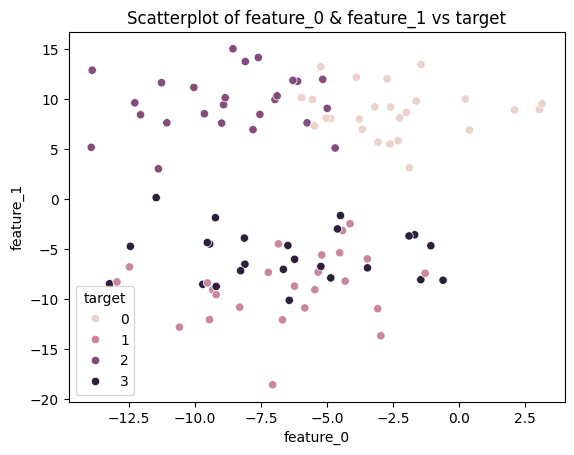

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x=df.columns[0], y=df.columns[1], hue='target')
plt.title(f'Scatterplot of {df.columns[0]} & {df.columns[1]} vs target')
plt.show()

#### Data Scaling

As we can see from the descriptive statistics above, the features have different means, standard deviations, and numeric ranges. Distance-based clustering algorithms, like KMeans, compute distances between data points. Features with larger numeric ranges can dominate the distance measure and disproportionately influence the clustering result, even if they are not inherently more important. Scaling ensures that all features contribute more equally.

Depending on the data, there are various methods for doing this, like described in the [User Guide on data processing](https://scikit-learn.org/stable/modules/preprocessing.html), or in the [Examples on preprocessing](https://scikit-learn.org/stable/auto_examples/preprocessing/index.html).

We will use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which works well for data without outliers, and scales the features to have zero mean and unit variance.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=[f'feature_{i}' for i in range(0, X.shape[1])])
df_scaled['target'] = y

df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_0,100.0,-1.154632e-16,1.005038,-2.105320,-0.764064,0.049998,0.702085,2.478985
feature_1,100.0,1.887379e-17,1.005038,-2.236170,-0.937232,0.066057,0.924874,1.601767
feature_2,100.0,2.386980e-17,1.005038,-2.689426,-0.655682,0.042708,0.753273,2.208106
feature_3,100.0,2.886580e-17,1.005038,-1.787755,-0.681658,0.062848,0.748021,3.286016
feature_4,100.0,-2.070566e-16,1.005038,-1.758864,-0.659279,-0.273728,0.761114,2.753415
target,100.0,1.500000e+00,1.123666,0.000000,0.750000,1.500000,2.250000,3.000000


## Select and train a model

We want to make use of the basic KMeans clustering algorithm.  
For clustering, we do not necessarely need to split our data for training and test.  

* We import the model [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and initialize the corresponding Python object using `()` **while also setting specific model parameters**
* Model training is started using the method [`.fit_predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_predict)
* We pass the data as a whole to this method
* The model parameters are now adjusted to predict the target (clusters) as accurately as possible based on the associated feature

In [10]:
from sklearn.cluster import KMeans

# Initialize model with model parameters
# - n_clusters: number of expected clusters 
#   -> since we do not know any better yet, we assume it may be 2
model = KMeans(
    n_clusters=2
)

In [11]:
# Unsupervised training 
# - “Fitting” the model to the training data without known labels
# - return the estimated cluster assignments for the samples
y_pred = model.fit_predict(X_scaled)

### Evaluation

We now want to check how well the model can predict the actual clusters for our data by comparing the predictions with the known classes derive metrics for evaluating the model quality.

* Suitable clustering metrics are described, e.g., in the [User Guide - Clustering Evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)
* We choose
  * [Silhouette Coefficient](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient):
    * The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
    * The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
  * [Homogeneity-Completeness measures](https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure):
    * Homogeneity and Completeness are bounded below by 0.0 and above by 1.0 (higher is better)
    * V-measure is the harmonic mean of both
* In general, it makes sense to calculate several metrics in order to get a better impression of the model quality

In [12]:
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score

sc = silhouette_score(X_scaled, y_pred, metric='euclidean')
hcv = homogeneity_completeness_v_measure(y, y_pred)

print('silhouette_score: ', sc)
print('homogeneity_completeness_v_measure: ', hcv)

silhouette_score:  0.281290416197809
homogeneity_completeness_v_measure:  (0.34525937754223096, 0.7635259980029556, 0.4755014209638048)


## Parameter tuning

We did run the KMeans clustering under the assumption there may be 2 clusters. For KMeans, this value is a model parameter. And we can try other values to see whether the metrics for evaluation, i.e., the clustering quality may improve.

### Exercise

Now it's your turn! Check for different values for the parameter `n_clusters` to see if the values of the evaluation metrics can be improved. The goal is to find the value for `n_clusters` that achieves the best evaluation result for both `silhouette_score` and `v_measure`. Plotting the evaluation metrics may help to get a better impression.

Hint: a loop is the easiest approach

**You may ask our assistant bia-bob for help.**

In [13]:
# ToDo: Parameter tuning for KMeans

## Dimension Reduction

As shown above, visualizing 5-dimensional data in a meaningful way is not feasible. This is where dimensionality reduction becomes useful. It allows us to transform high-dimensional data into a lower-dimensional representation that can be visualized in two dimensions.

Several algorithms for dimensionality reduction are available and described in the scikit-learn [User Guide on decomposition](https://scikit-learn.org/stable/modules/decomposition.html) or [User Guide for manifold learning](https://scikit-learn.org/stable/modules/manifold.html)

In this example, we will apply [Principal component analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), a linear method that preserves global variance structure.

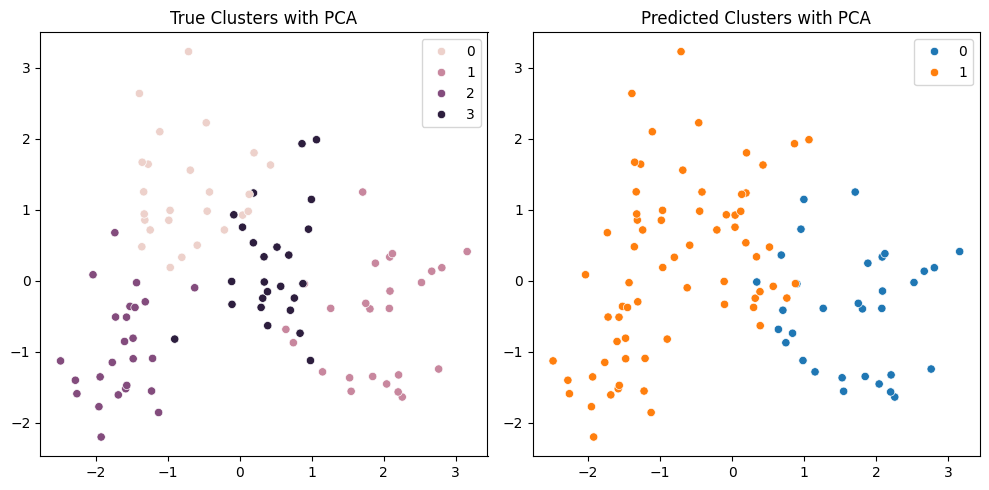

In [21]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# Apply KMeans clustering, you can play with the n_cluster parameter
y_pred_final = KMeans(n_clusters=2).fit_predict(X_scaled)

# Apply PCA to transform data into 2 dimensions
pca_ = PCA(n_components=2)
X_pca = pca_.fit_transform(X_scaled)

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot true clusters with PCA
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, ax=ax1)
ax1.set_title("True Clusters with PCA")

# Plot predicted clusters with PCA
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred_final, ax=ax2)
ax2.set_title("Predicted Clusters with PCA")

# Layout so plots do not overlap
fig.tight_layout()
plt.show()